In [1]:
# Making a 3D datasets
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m,3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:,0],X[:,1] = np.cos(angles),np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m,3)
X = Rotation.from_rotvec([np.pi/29, -np.pi / 20,np.pi /4]).apply(X)
X += [0.2,0,0.2]


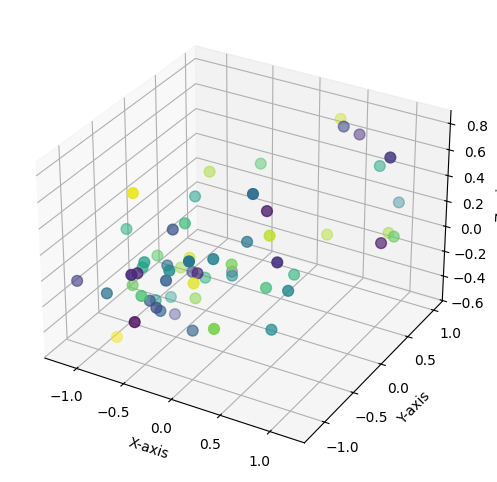

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("viridis", m)


ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, s=60)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [4]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',as_frame=False)
X_train,y_train = mnist.data[:60_000],mnist.target[:60_000]
X_test,y_test = mnist.data[60_000:],mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [8]:
d

np.int64(154)

In [9]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [10]:
pca.n_components_

np.int64(154)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    'pca__n_components': np.arange(10,80),
    'randomforestclassifier__n_estimators': np.arange(50,500)
}
rnd_search = RandomizedSearchCV(clf,param_distrib,n_iter=10,cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000],y_train[:1000])

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'pca__n_components': array([10, 11... 78, 79]), 'randomforestclassifier__n_estimators': array([ 50, ...97, 498, 499])}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [12]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [13]:
X_recovered = pca.inverse_transform(X_reduced)

In [14]:
rnd_pca = PCA(n_components=154,svd_solver='randomized',random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [15]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [16]:
filename = 'my_mnist.mmap'
X_mmap = np.memmap(filename,dtype='float32',mode='write',shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [17]:
X_mmap = np.memmap(filename,dtype='float32',mode='readonly').reshape(-1,784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154,batch_size=batch_size)
inc_pca.fit(X_mmap)

,n_components,154
,whiten,False
,copy,True
,batch_size,600


In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5_000,0.1
d = johnson_lindenstrauss_min_dim(m,eps = e)
d

np.int64(7300)

In [19]:
n = 20_000
np.random.seed(42)
p = np.random.randn(d,n) / np.sqrt(d)

X = np.random.randn(m,n)
X_reduced = X @ p.T

In [20]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=e,random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [ ]:
# components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
# X_recovered = X_reduced @ components_pinv.T

In [21]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2,n_neighbors=10,random_state=42)
X_unrolled = lle.fit_transform(X_swiss)